## Task 3

In [8]:
# to create a spark session object
from pyspark.sql import SparkSession
# data types
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import year
from pyspark.sql.functions import col as spark_col
from pyspark.sql.functions import mean, max, min, count



In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Open a session with Postgre
spark_postgre = SparkSession \
    .builder \
    .appName("bugs_v1") \
    .config("spark.jars", "/Users/zhao/Desktop/postgresql-42.6.0.jar") \
    .getOrCreate()

23/07/21 10:57:34 WARN Utils: Your hostname, ZhaodeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.210.76.133 instead (on interface en0)
23/07/21 10:57:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/07/21 10:57:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
# Read data from PostgreSQL running at localhost
params = spark_postgre.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/smm695_fcp") \
    .option("user", "postgres") \
    .option("password", "0776@zzW") \
    .option("driver", "org.postgresql.Driver")

df_0 = params \
    .option("dbtable", "final.bugs") \
    .load()

df_0.printSchema()

root
 |-- id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- classification: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- qa_contact: string (nullable = true)
 |-- creation_time: string (nullable = true)
 |-- last_change_time: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- cf_last_resolved: string (nullable = true)
 |-- op_sys: string (nullable = true)
 |-- resolution: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- is_creator_accessible: string (nullable = true)
 |-- is_confirmed: string (nullable = true)
 |-- votes: string (nullable = true)
 |-- url: string (nullable = true)
 |-- severity: string (nullable = true)
 |-- product: string (nullable = true)
 |-- is_cc_accessible: string (nullable = true)
 |-- version: string (nullable = true)
 |-- update_token: string (nullable = true)
 |-- component: string (nullable =

In [5]:
df_0.describe([ 'id',
               'type_new','product_new','classification_new',
               'priority_new','resolution_new',
               'severity_new','status_new',
               'comment_count','creation_time_new',
               'cf_last_resolved_new',
               'op_sys_new','platform_new']).show()

23/07/21 10:57:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+--------+--------------------+------------------+------------+--------------+--------------+----------+------------------+----------+------------+
|summary|                id|type_new|         product_new|classification_new|priority_new|resolution_new|  severity_new|status_new|     comment_count|op_sys_new|platform_new|
+-------+------------------+--------+--------------------+------------------+------------+--------------+--------------+----------+------------------+----------+------------+
|  count|            207894|  207894|              207894|            207894|      207894|        207894|        207894|    207894|            207894|    207894|      207894|
|   mean|107617.39369582575|    null|                null|              null|        null|          null|          null|      null|10.042415846537178|      null|        null|
| stddev| 62076.18591163021|    null|                null|              null|        null|          null|          null|     

In [6]:
# Create a new DataFrame to save the selected variables
df = df_0.select(F.col('id'),F.col("type_new"), F.col("product_new"),F.col('classification_new'),
                F.col('comment_count'), F.col('op_sys_new'),F.col('platform_new'),
                F.col("creation_time_new"), F.col("cf_last_resolved_new"),
                F.col("priority_new"),F.col("resolution_new"),
                F.col("severity_new"),F.col("status_new"),
                F.col("is_open")
                
                )

df.describe().show()

+-------+------------------+--------+--------------------+------------------+------------------+----------+------------+------------+--------------+--------------+----------+-------+
|summary|                id|type_new|         product_new|classification_new|     comment_count|op_sys_new|platform_new|priority_new|resolution_new|  severity_new|status_new|is_open|
+-------+------------------+--------+--------------------+------------------+------------------+----------+------------+------------+--------------+--------------+----------+-------+
|  count|            207894|  207894|              207894|            207894|            207894|    207894|      207894|      207894|        207894|        207894|    207894| 207894|
|   mean|107617.39369582575|    null|                null|              null|10.042415846537178|      null|        null|        null|          null|          null|      null|   null|
| stddev| 62076.18591163021|    null|                null|              null|14.16833

In [9]:
# add a new column lifespan: how long the issue existed
df = df.withColumn('span_days', F.datediff(df.cf_last_resolved_new, df.creation_time_new)) 
# Adding a new column "year" by extracting the year from "creation_time"
df = df.withColumn("year", year("creation_time_new"))
# Convert the column to numeric type
df = df.withColumn("comment_count", spark_col("comment_count").cast("int"))


In [11]:
df_d = df.select(['type_new','product_new','classification_new',
           'op_sys_new','platform_new','priority_new',
           'resolution_new','severity_new',
           'status_new','is_open','comment_count','span_days']).describe().show(5)



+-------+--------+--------------------+------------------+----------+------------+------------+--------------+--------------+----------+-------+------------------+------------------+
|summary|type_new|         product_new|classification_new|op_sys_new|platform_new|priority_new|resolution_new|  severity_new|status_new|is_open|     comment_count|         span_days|
+-------+--------+--------------------+------------------+----------+------------+------------+--------------+--------------+----------+-------+------------------+------------------+
|  count|  207894|              207894|            207894|    207894|      207894|      207894|        207894|        207894|    207894| 207894|            207894|            207755|
|   mean|    null|                null|              null|      null|        null|        null|          null|          null|      null|   null|10.042415846537178|402.40747996438114|
| stddev|    null|                null|              null|      null|        null|   

## Machine Learning on Predicting Analysis

In [12]:
# Loading the library
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import year

## Prediction of the severity classification -Random Forest

In [13]:
grouped_data = df.groupBy("severity_new").agg(
    mean("span_days").alias("span_days"),
    mean("comment_count").alias("comment_count"),
    # min("column3").alias("min_column3"),
    count("id").alias("id")
)

# Step 4: Show the results
grouped_data.show()


+--------------+------------------+------------------+------+
|  severity_new|         span_days|     comment_count|    id|
+--------------+------------------+------------------+------+
|          High| 263.2042011370987| 11.52805931569281| 29402|
|           Low| 427.8129901467927| 7.805382606949187|  4979|
|Severity S1-S4| 7595.315151515151|21.175757575757576|   165|
|        Medium|448.99846509575036| 9.516277477501202|151897|
|             -| 7533.037037037037| 32.81481481481482|    27|
|      Critical|192.77736271946208|12.139329723674384| 21424|
+--------------+------------------+------------------+------+



In [14]:
columns_to_encode = ['type_new',
                     'product_new',
               'priority_new',
               'resolution_new',
               'classification_new',
               'status_new',
               'op_sys_new',
               'platform_new']

In [15]:
indexers = []
encoders = []

for col in columns_to_encode:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[col + "_encoded"])
    indexers.append(indexer)
    encoders.append(encoder)

# Create a list of all the feature columns that will be used in the VectorAssembler
feature_cols = [col + "_encoded" for col in columns_to_encode]
# +['span_days']+['comment_count']

In [16]:
# Apply all transformations to the DataFrame
df_encoded = df
for indexer, encoder in zip(indexers, encoders):
    df_encoded = indexer.fit(df_encoded).transform(df_encoded)
    df_encoded = encoder.fit(df_encoded).transform(df_encoded)

# Create the VectorAssembler to combine all encoded features
assembler = VectorAssembler(inputCols=feature_cols, 
                            outputCol="features")

# Apply the VectorAssembler to the DataFrame
df_assembled = assembler.transform(df_encoded)

# The "df_assembled" DataFrame now contains the "features" column with the combined encoded features
df_assembled.select(['features']).show()

+--------------------+
|            features|
+--------------------+
|(47,[0,4,14,19,28...|
|(47,[0,4,14,21,29...|
|(47,[0,4,13,18,28...|
|(47,[1,4,13,22,29...|
|(47,[0,4,13,21,29...|
|(47,[4,14,19,28,3...|
|(47,[1,3,13,21,27...|
|(47,[0,4,13,19,27...|
|(47,[0,4,13,20,28...|
|(47,[0,3,13,21,27...|
|(47,[4,13,22,30,3...|
|(47,[0,3,13,18,27...|
|(47,[0,4,14,18,29...|
|(47,[0,4,13,19,28...|
|(47,[0,4,14,22,28...|
|(47,[0,5,14,21,28...|
|(47,[0,5,13,21,28...|
|(47,[0,3,13,21,27...|
|(47,[4,13,20,29,3...|
|(47,[0,6,13,18,27...|
+--------------------+
only showing top 20 rows



In [17]:
# Indexing 'binary'
idx_1 = StringIndexer() \
        .setInputCol("severity_new") \
        .setOutputCol("severity_idx")
        
df_assembled = idx_1.fit(df_assembled).transform(df_assembled)


In [18]:
df_assembled.describe().show()

+-------+------------------+--------+--------------------+------------------+------------------+----------+------------+------------+--------------+--------------+----------+-------+------------------+------------------+-------------------+------------------+------------------+--------------------+------------------------+-------------------+------------------+------------------+------------------+
|summary|                id|type_new|         product_new|classification_new|     comment_count|op_sys_new|platform_new|priority_new|resolution_new|  severity_new|status_new|is_open|         span_days|              year|     type_new_index| product_new_index|priority_new_index|resolution_new_index|classification_new_index|   status_new_index|  op_sys_new_index|platform_new_index|      severity_idx|
+-------+------------------+--------+--------------------+------------------+------------------+----------+------------+------------+--------------+--------------+----------+-------+--------------

In [19]:
# Step 5: Split the data into training and testing sets
train_data, test_data = df_assembled.randomSplit([0.7, 0.3], seed=42)


In [20]:
# Step 6: Build the machine learning model (Random Forest Classifier)
rf = RandomForestClassifier(labelCol="severity_idx", featuresCol="features")

# Step 7: Train the model on the training data
model = rf.fit(train_data)

# Step 8: Evaluate the model on the testing data
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="severity_idx", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 73.08%


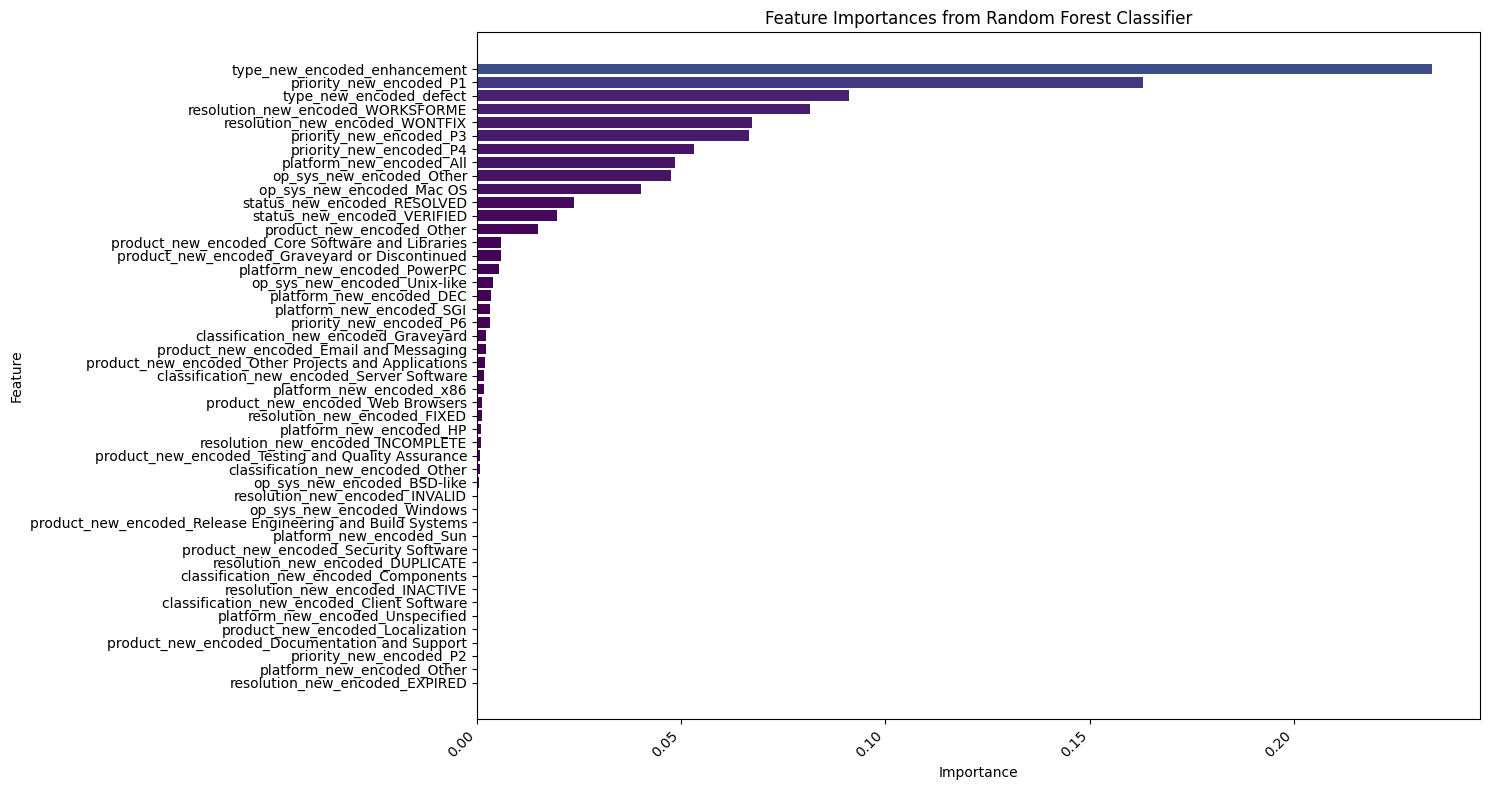

In [68]:
# Get feature importances
importances = model.featureImportances

# Get the dict_values object from the DataFrame
attr_data = df_assembled.schema["features"].metadata["ml_attr"]["attrs"].values()

# Convert the dict_values object to a list
attr_list = list(attr_data)

# mapping the index and the column name
attrs = sorted(
    (attr["idx"], attr["name"])
    for attr in attr_list[0]
)

# Create a DataFrame to hold feature names and their importances
importance_df = pd.DataFrame({'Feature': [name for idx, name in attrs],
                              'Importance': [importances[idx] for idx, name in attrs]
                             })

# Sort the DataFrame in descending order of importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)


# Create a colormap using 'viridis'
colormap = plt.cm.viridis

# Create a horizontal bar chart for feature importances with colors based on importance values
plt.figure(figsize=(15, 8))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color=colormap(importance_df['Importance']))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Classifier')

# Add a color bar to show the mapping between importance values and colors
# cbar = plt.colorbar(bars)
# cbar.ax.set_ylabel('Importance')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Prediction of the span_days

In [69]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
import scipy.stats as stats

In [70]:
numerical_cols = ["year", "span_days", "comment_count"]


In [71]:
df = df.withColumn("span_days", df["span_days"].cast(IntegerType()))
df = df.withColumn("comment_count", df["comment_count"].cast(IntegerType()))


In [72]:
df=df.na.drop("any")

In [73]:
columns_to_encode = ['type_new',
                     'product_new',
               'priority_new',
               'resolution_new',
               'classification_new',
               'status_new',
               'op_sys_new',
               'platform_new',
               'severity_new']

In [74]:
# Features table
# columns_to_encode = ["priority_new", "resolution_new", "severity_new", "status_new",'year']

indexers = []
encoders = []

for col in columns_to_encode:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[col + "_encoded"])
    indexers.append(indexer)
    encoders.append(encoder)

# Create a list of all the feature columns that will be used in the VectorAssembler
# feature_cols = [col + "_encoded" for col in columns_to_encode]

# Apply all transformations to the DataFrame
df_encoded = df
for indexer, encoder in zip(indexers, encoders):
    df_encoded = indexer.fit(df_encoded).transform(df_encoded)
    df_encoded = encoder.fit(df_encoded).transform(df_encoded)



In [75]:
# Create the VectorAssembler to combine all encoded features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


# Apply the VectorAssembler to the DataFrame
df_assembled_lr = assembler.transform(df_encoded)

# The "df_assembled" DataFrame now contains the "features" column with the combined encoded features
# df_assembled.select(['features']).show()

# # Applying some transformation: String indexer
# # Indexing 'binary'
# idx_1 = StringIndexer() \
#         .setInputCol("type_new") \
#         .setOutputCol("type_idx")
        
# df_assembled = idx_1.fit(df_assembled).transform(df_assembled)

# Step 5: Split the data into training and testing sets
train_data, test_data = df_assembled_lr.randomSplit([0.7, 0.3], seed=42)

svr_model = LinearRegression(featuresCol='features', labelCol='span_days', regParam=0.0)
# Fit the model to the training data
svr_model_fit = svr_model.fit(train_data)

# Make predictions on the test data
predictions = svr_model_fit.transform(test_data)

# Evaluate the model's performance using RMSE
evaluator = RegressionEvaluator(labelCol='span_days', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")


23/07/21 11:54:26 WARN Instrumentation: [159d4366] regParam is zero, which might cause numerical instability and overfitting.
23/07/21 11:54:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/07/21 11:54:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Squared Error (RMSE): 834.2891761795684


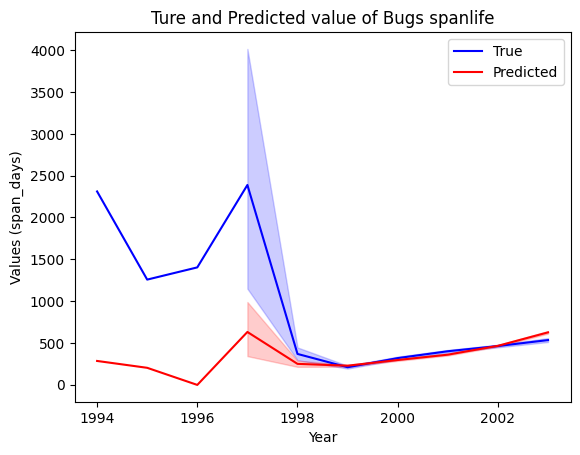

In [78]:
# Convert the predictions DataFrame to a Pandas DataFrame
predictions_pd = predictions.select('span_days', 'prediction', 'year').toPandas()

# Create a line chart using Seaborn
sns.lineplot(x='year', y='span_days', data=predictions_pd, color='blue', label='True')
sns.lineplot(x='year', y='prediction', data=predictions_pd, color='red', label='Predicted')

plt.xlabel('Year')
plt.ylabel('Values (span_days)')
plt.title('Ture and Predicted value of Bugs spanlife')
plt.legend()
plt.show()